In [1]:
import gymnasium as gym
import numpy as np
import torch
from torch import nn
from tqdm import tqdm
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from gymnasium.wrappers import RecordEpisodeStatistics, RecordVideo
from IPython.display import display, clear_output

# Device setup (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


Using device: cuda


  0%|          | 0/10000 [00:00<?, ?it/s]/tmp/ipykernel_7467/3743642644.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(state).to(device)
  1%|          | 92/10000 [02:47<5:00:37,  1.82s/it]


KeyboardInterrupt: 

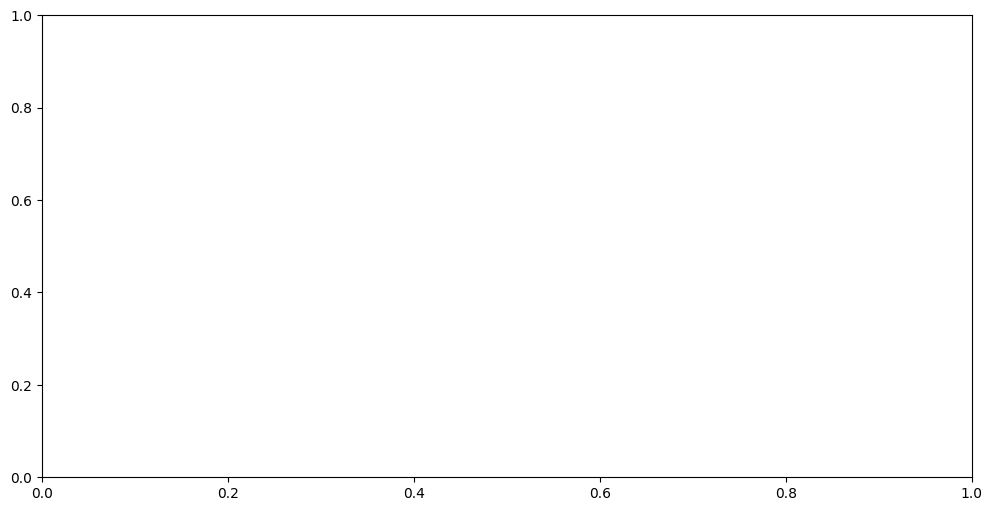

In [11]:
import gymnasium as gym
import numpy as np
import torch
from torch import nn
from tqdm import tqdm
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from gymnasium.wrappers import RecordEpisodeStatistics, RecordVideo
from IPython.display import display, clear_output

# Device setup (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, max_action):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(state_dim,128),
            nn.ReLU(),
            nn.Linear(128,128),
            nn.ReLU(),
            nn.Linear(128,action_dim),
            nn.Tanh()
        )
        self.max_action = max_action

    def forward(self, state):
        x = torch.tensor(state)
        action = self.layers(x) * self.max_action
        return action
    
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(state_dim + action_dim,128),
            nn.ReLU(),
            nn.Linear(128,128),
            nn.ReLU(),
            nn.Linear(128, action_dim)
        )
    
    def forward(self, state, action):
        sa = torch.cat([state, action], 1)
        Q = self.layers(sa)
        return Q

def polyak_average(net_target, net_source, tau):
    # --- Perform Polyak Averaging Update ---
    # print(f"Performing Polyak update with tau={tau}...")
    with torch.no_grad(): # IMPORTANT: No gradient tracking needed for this update
        # Iterate through the state dictionary of the target network
        target_state_dict = net_target.state_dict()
        source_state_dict = net_source.state_dict()

        for key in target_state_dict:
            if key not in source_state_dict:
                print(f"Warning: Key {key} not found in source state_dict. Skipping.")
                continue

            target_tensor = target_state_dict[key]
            source_tensor = source_state_dict[key]

            # Apply the Polyak averaging formula IN-PLACE
            # target_tensor = tau * source_tensor + (1 - tau) * target_tensor
            target_tensor.mul_(1.0 - tau) # Multiply target by (1-tau)
            target_tensor.add_(source_tensor * tau) # Add tau * source

class ReplayBuffer:
    def __init__(self, capacity, state_dim, action_dim):
        # Use separate tensors for better slicing and type handling
        self.states = torch.zeros((capacity, state_dim), dtype=torch.float32, device='cpu')
        self.actions = torch.zeros((capacity, action_dim), dtype=torch.float32, device='cpu')
        self.rewards = torch.zeros((capacity, 1), dtype=torch.float32, device='cpu')
        self.next_states = torch.zeros((capacity, state_dim), dtype=torch.float32, device='cpu')
        self.dones = torch.zeros((capacity, 1), dtype=torch.float32, device='cpu') # Use float for (1-dones) multiplier

        self.capacity = capacity
        self.ptr = 0 # Pointer to current insertion index
        self.size = 0 # Current number of samples in buffer

    def add(self, state, action, reward, next_state, done):
        # Convert inputs to tensors if they aren't already
        state = torch.as_tensor(state, dtype=torch.float32, device='cpu')
        action = torch.as_tensor(action, dtype=torch.float32, device='cpu')
        reward = torch.as_tensor([reward], dtype=torch.float32, device='cpu')
        next_state = torch.as_tensor(next_state, dtype=torch.float32, device='cpu')
        done = torch.as_tensor([done], dtype=torch.float32, device='cpu') # Store 0.0 or 1.0

        # Insert data at the current pointer position
        self.states[self.ptr] = state
        self.actions[self.ptr] = action
        self.rewards[self.ptr] = reward
        self.next_states[self.ptr] = next_state
        self.dones[self.ptr] = done

        # Update pointer and size
        self.ptr = (self.ptr + 1) % self.capacity # Rolling buffer index
        self.size = min(self.size + 1, self.capacity)

    def sample(self, batch_size):
        # Generate random indices, ensuring we don't sample beyond current size
        random_indices = torch.randint(0, self.size, (batch_size,), device='cpu')

        # Sample using the random indices
        states = self.states[random_indices]
        actions = self.actions[random_indices]
        rewards = self.rewards[random_indices]
        next_states = self.next_states[random_indices]
        dones = self.dones[random_indices]

        # Return tuple of tensors, move to correct device
        return (
            states.to(device),
            actions.to(device),
            rewards.to(device),
            next_states.to(device),
            dones.to(device)
        )
    
# constants
num_episodes = 10000
training_period = num_episodes / 10
env = gym.make('MountainCarContinuous-v0', render_mode='rgb_array')
env = RecordVideo(env, video_folder="mountaincar-continuous-agent", name_prefix="training",
                  episode_trigger=lambda x: x % training_period == 0)
env = RecordEpisodeStatistics(env, buffer_length=num_episodes)
state_dim = 2
action_dim = 1
max_action = float(env.action_space.high[0])

# actor hyperparameters
alpha_actor = 0.1

# critic hyperparameters
alpha_critic = 0.1

gamma = 0.999
batch_size = 512
tau = 0.005 # this is the target network update rate
episodes_actor = 10000
buffer_size = 1000000

initial_noise_sigma = 0.1
noise_sigma_min = 0.01
noise_sigma_decay_episodes = int(num_episodes * 0.7) # Example decay period
noise_sigma_decay = (initial_noise_sigma - noise_sigma_min) / noise_sigma_decay_episodes if noise_sigma_decay_episodes > 0 else 0
current_noise_sigma = initial_noise_sigma

# initialize networks
actor = Actor(state_dim, action_dim, max_action).to(device)
critic = Critic(state_dim, action_dim).to(device)
actor_target = Actor(state_dim, action_dim, max_action).to(device)
critic_target = Critic(state_dim, action_dim).to(device)
# Set target networks to evaluation mode
actor_target.eval()
critic_target.eval()
loss_critic = nn.MSELoss()
actor_optimizer = optim.Adam(actor.parameters(), lr=alpha_actor)
critic_optimizer = optim.Adam(critic.parameters(), lr=alpha_critic)
replay_buffer = ReplayBuffer(buffer_size, state_dim, action_dim)

# --- Plotting Setup ---
all_episode_rewards = []
moving_avg_window = 100
update_plot_every = 100
fig, ax = plt.subplots(figsize=(12, 6))

for episode in tqdm(range(num_episodes)):
    # print(f"espisode {episode}")
    
    # 1) reset environment
    obs, info = env.reset()
    done = False
    episode_reward = 0

    while not done:
        # a) Get deterministic action from Actor network
        with torch.no_grad():
            a_t = actor(obs)
        noise = torch.normal(0, current_noise_sigma, size=a_t.shape, device=device) # noise tensor
        a_t = a_t + noise                 # add noise
        a_t = torch.clamp(a_t, -max_action, max_action) # clip a

        # b) execute action
        a_np = a_t.cpu().numpy()
        next_obs, reward, terminated, truncated, info = env.step(a_np)
        done = terminated or truncated
        episode_reward += reward

        # c) store transition
        replay_buffer.add(obs, a_np, reward, next_obs, done)
    
        # d) update current state
        obs = next_obs

        # e) sample and learn if the buffer is large enough
        if replay_buffer.size > (1*batch_size):
            # i) sample N random transitions (mini-batch)
            sb,ab,rb,sb_p,doneb = replay_buffer.sample(batch_size) # (batch_size, 1) tensors
            # ii) calculate critic targets using target network
            with torch.no_grad():
                ab_next_t = actor_target(sb_p)
                targetb_q = critic_target(sb_p, ab_next_t)
                y = rb + gamma * (1.0-doneb) * targetb_q # calculate all in atch

            # iii) update critic network using MSE
            current_q = critic(sb,ab)
            critic_loss = F.mse_loss(current_q, y)
            critic_optimizer.zero_grad()
            critic_loss.backward()
            critic_optimizer.step()

            # iv) update actor network
            # Freeze critic parameters during actor update
            for p in critic.parameters():
                p.requires_grad = False
            ab_t = actor(sb)
            qb_t = critic(sb,ab_t)
            actor_loss = -qb_t.mean()
            actor_optimizer.zero_grad()
            actor_loss.backward()
            actor_optimizer.step()

            # Unfreeze critic parameters
            for p in critic.parameters():
                p.requires_grad = True
            
            # v) perform soft updates on both target networks
            polyak_average(critic_target, critic, tau)
            polyak_average(actor_target, actor, tau)
        
    # Record final episode reward from wrapper info if available
    if 'episode' in info:
        final_episode_return = info['episode']['r']
        all_episode_rewards.append(final_episode_return)

    # episode done
    current_noise_sigma = max(noise_sigma_min, current_noise_sigma - noise_sigma_decay) # Linear decay example

    # --- Update Plot Periodically ---
    if (episode + 1) % update_plot_every == 0 and len(all_episode_rewards) > 0:
        clear_output(wait=True) # Clear previous output
        ax.cla() # Clear axes for fresh plot

        # Replot data
        ax.plot(all_episode_rewards, label='Episode Reward', alpha=0.6)
        if len(all_episode_rewards) >= moving_avg_window:
            moving_avg = np.convolve(all_episode_rewards, np.ones(moving_avg_window)/moving_avg_window, mode='valid')
            ax.plot(np.arange(moving_avg_window - 1, len(all_episode_rewards)), moving_avg, label=f'{moving_avg_window}-Ep Moving Avg', color='red')

        # Reset labels and title
        ax.set_xlabel("Episode")
        ax.set_ylabel("Total Reward")
        ax.set_title(f"Training Progress - Episode {episode + 1}")
        ax.legend()

        # Display the updated figure in the cell output
        display(fig)

env.close()